<a href="https://colab.research.google.com/github/ValensioLeonard/Bangkit_Final_Capstone_Vivere/blob/main/Machine_Learning/Dental_Health_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dental Health Classifier, Bangkit Final Capstone

In [ ]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from shutil import copyfile
import re
from shutil import move


from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Bangkit Final Project Files'

/content/gdrive/MyDrive/Bangkit Final Project Files


## Generate Dataset Folder

In [ ]:
# Define our directories and files
train_dir = 'Dataset/Training/'
validation_dir = 'Dataset/Validation/'

In [ ]:
# Use Temporary dir

# Populate Temporary Directory
def copy_file(source, destination):
  list_to_copy = os.listdir(source)
  for member in tqdm(list_to_copy):
    source_file = os.path.join(source, member)
    dest_file = os.path.join(destination, member)
    copyfile(source_file, dest_file)

copy_file(train_dir, 'Dataset/Dataset2/Training')
copy_file(validation_dir, 'Dataset/Dataset2/Validation')

100%|██████████| 113/113 [01:52<00:00,  1.00it/s]


In [ ]:
# Update Training and Validation Dir

train_dir = '../Dataset2/Training'
validation_dir = '../Dataset2/Validation'

## Move file to appropriate folder

In [ ]:
def move_to_class(dir):
  files = os.listdir(dir)
  for file in files:
    source_file = os.path.join(dir, file)
    try:
      if re.findall(r'^(.+)\.[0-9]+', file)[0] == 'no':
        dest_file = os.path.join(dir, 'Healthy' ,file)
        move(source_file, dest_file)
      else:
        dest_file = os.path.join(dir, 'Caries' ,file)
        move(source_file, dest_file)
    except:
      print('Skipped: ' + file)

move_to_class(train_dir)
move_to_class(validation_dir)

Skipped: Caries
Skipped: Healthy (1)
Skipped: Caries
Skipped: Healthy


## Convert file format to PNG

In [ ]:
from PIL import Image
import os

def convert_to_png(dir, verbose = False, remove_former = False):
  for file in os.listdir(dir):
    if file.endswith(".png") == False:
        im = Image.open(os.path.join(dir, file))
        name = re.findall(r'(.+)\.[\w+]+', file)[0] + '.png'        
        rgb_im = im.convert('RGB')
        rgb_im.save(os.path.join(dir, name))

        if remove_former:
          os.remove(os.path.join(dir, file))

        if verbose:
          print('converted ' + file + ' to ' + name)
        continue
    else:
        continue

In [ ]:
convert_to_png(os.path.join(train_dir, 'Healthy'), verbose = True, remove_former = True)
convert_to_png(os.path.join(train_dir, 'Caries'),  remove_former = True)
convert_to_png(os.path.join(validation_dir, 'Healthy'),  remove_former = True)
convert_to_png(os.path.join(validation_dir, 'Caries'),  remove_former = True)

## Initiate Image Generator

In [ ]:
train_heathy_dir = os.path.join(train_dir, 'Healthy')
train_caries_dir = os.path.join(train_dir, 'Caries')
validation_healthy_dir = os.path.join(validation_dir, 'Healthy')
validation_caries_dir = os.path.join(validation_dir, 'Caries')

train_heathy_fnames = os.listdir(train_heathy_dir)
train_caries_fnames = os.listdir(train_caries_dir)
validation_healthy_fnames = os.listdir(validation_healthy_dir)
validation_caries_fnames = os.listdir(validation_caries_dir)

print(len(train_heathy_fnames))
print(len(train_caries_fnames))
print(len(validation_healthy_fnames))
print(len(validation_caries_fnames))

56
57
24
24


In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255.)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    class_mode = 'binary',
                                                    batch_size = 10,
                                                    target_size = (224, 224))     

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                    class_mode = 'binary',
                                                    batch_size = 10,
                                                    target_size = (224, 224))

# Expected Output:
# Found 113 images belonging to 2 classes.
# Found 48 images belonging to 2 classes.

Found 113 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


## Modelling

In [ ]:
import tensorflow_hub as hub

In [ ]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
feature_extractor_layer = hub.KerasLayer(
  feature_extractor_model, input_shape = (224, 224, 3), trainable=False)

In [ ]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  # tf.keras.layers.Conv2D(16, 3, activation ='relu', input_shape = (224, 224, 3)),
  # tf.keras.layers.MaxPooling2D(3, 3), 
  # tf.keras.layers.Conv2D(16, 3, activation ='relu', input_shape = (224, 224, 3)),
  # tf.keras.layers.MaxPooling2D(3, 3), 
  # tf.keras.layers.Flatten(),
  # tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1, activation ='sigmoid')
])

model.summary()

model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history = model.fit_generator(train_generator,
                    validation_data = validation_generator,
                    # steps_per_epoch = 100,
                    # validation_steps = 50,
                    verbose = 1,
                    epochs = 50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
12/12 [==============================] - 109s 7s/step - loss: 0.8445 - acc: 0.5667 - val_loss: 0.5031 - val_acc: 0.7708
Epoch 2/50
12/12 [==============================] - 6s 483ms/step - loss: 0.5850 - acc: 0.6538 - val_loss: 0.4260 - val_acc: 0.8125
Epoch 3/50
12/12 [==============================] - 6s 518ms/step - loss: 0.5370 - acc: 0.6716 - val_loss: 0.3777 - val_acc: 0.8542
Epoch 4/50
12/12 [==============================] - 6s 487ms/step - loss: 0.4198 - acc: 0.8186 - val_loss: 0.3557 - val_acc: 0.8750
Epoch 5/50
12/12 [==============================] - 6s 494ms/step - loss: 0.4280 - acc: 0.8494 - val_loss: 0.3256 - val_acc: 0.8542
Epoch 6/50
12/12 [==============================] - 6s 497ms/step - loss: 0.3091 - acc: 0.8519 - val_loss: 0.3063 - val_acc: 0.8750
Epoch 7/50
12/12 [==============================] - 6s 494ms/step - loss: 0.2572 - acc: 0.9256 - val_loss: 0.2860 - val_acc: 0.8750
Epoch 8/50
12/12 [==============================] - 6s 489ms/step - loss: 0.2

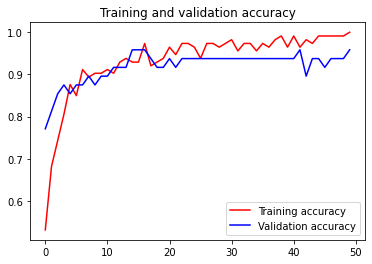

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Saving Existing Model

In [ ]:
!mkdir "Machine_Learning_Models"

In [ ]:
!mkdir "Machine_Learning_Models/model_leo/modelv1"

In [ ]:
# Save model to desired path

saved_model_path = "Machine_Learning_Models/model_leo/modelv1"

model.save(saved_model_path)

INFO:tensorflow:Assets written to: Machine_Learning_Models/model_leo/modelv1/assets


INFO:tensorflow:Assets written to: Machine_Learning_Models/model_leo/modelv1/assets


## Detecting Caries

In [ ]:
to_test = '../Dataset2/Validation/Caries/yes.501.png'

In [ ]:
import cv2

img = cv2.imread(to_test)
img = cv2.resize(img, (224,224),3)

b,g,r = cv2.split(img)           # get b, g, r
rgb_img1 = cv2.merge([r,g,b])     # switch it to r, g, b


# rgb_img1 = np.expand_dims(rgb_img1, axis = 0)
# rgb_img1 = tf.cast(rgb_img1, tf.float32)

In [ ]:
box = np.array([0, 0, 1, 1])
boxes = box.reshape([1, 1, 4])
colors = np.array([[1.0, 0.0, 0.0], [0.0, 0.0, 1.0]])

In [ ]:
x = tf.image.draw_bounding_boxes(
    img, boxes, colors, name=None
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


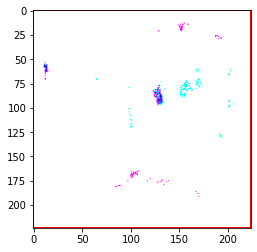

In [ ]:
plt.imshow(np.squeeze(x, axis = 0));